# Conditional generation via Bayesian optimization in latent space

This notebook reproduces part of the [Latent space optimization](http://krasserm.github.io/2018/04/07/latent-space-optimization/) blog by Martin Krasser using PyTorch and BoTorch libraries. The aim is to control the generation of samples from the latent space of a Variational Autoencoder using an objective function based on an additional classifier and Bayesian Optimization. 

### Model specification

In [43]:
#This code was partialy generated by chatGPT

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

# Define hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 30
batch_size = 128
learning_rate = 1e-3
latent_dim = 2

# Load MNIST dataset
train_dataset = datasets.MNIST(root='data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

# Define Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        z_mean = self.fc3(x)
        z_log_var = self.fc3(x)
        z = self.reparameterize(z_mean, z_log_var)
        return z, z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        eps = torch.randn_like(z_mean)
        return z_mean + torch.exp(z_log_var / 2) * eps

# Define Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x.view(-1, 1, 28, 28)

    # Define Classifier
class Classifier_ld(nn.Module):
    def __init__(self,latent_dim):
        super(Classifier_ld, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Let's train the VAE

In [47]:
#This code was partialy generated by chatGPT

# Instantiate the encoder, decoder and classifier
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
classifier = Classifier_ld(latent_dim).to(device)

# Define loss functions
reconstruction_loss = nn.BCELoss(reduction='sum')
classification_loss = nn.CrossEntropyLoss()

# Define optimizers
ae_optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
clf_optimizer = optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        # Train Autoencoder
        ae_optimizer.zero_grad()

        # Forward pass through encoder and decoder
        z, z_mean, z_log_var = encoder(data)
        recon_data = decoder(z)

        # Calculate reconstruction loss
        recon_loss = reconstruction_loss(recon_data, data)

        # Calculate KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var))

        # Calculate total loss
        ae_loss = (recon_loss + kl_loss) / batch_size

        # Backward pass and optimize
        ae_loss.backward(retain_graph=True)
        ae_optimizer.step()

        # Train classifier
        clf_optimizer.zero_grad()       

        # Forward pass through classifier
        z, _, _ = encoder(data)
        logits = classifier(z)

        # Calculate classification loss
        clf_loss = classification_loss(logits, labels)

        # Backward pass and optimize
        clf_loss.backward()
        clf_optimizer.step()

        if batch_idx % 100 == 0:
            print('Epoch [{}/{}], Batch [{}/{}], AE Loss: {:.4f}, CLF Loss: {:.4f}'
                  .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), ae_loss.item(), clf_loss.item()))

    # Save some images from the decoder
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device)
        recon_sample = decoder(sample).view(64, 1, 28, 28)
        save_image(recon_sample, 'samples/sample_{}.png'.format(epoch+1))

# Save the models
torch.save(encoder.state_dict(), 'vae_encoder.pth')
torch.save(decoder.state_dict(), 'vae_decoder.pth')
torch.save(classifier.state_dict(), 'vae_classifier.pth')

Epoch [1/30], Batch [1/469], AE Loss: 545.1435, CLF Loss: 2.3086
Epoch [1/30], Batch [101/469], AE Loss: 206.0907, CLF Loss: 1.2797
Epoch [1/30], Batch [201/469], AE Loss: 193.6258, CLF Loss: 0.9979
Epoch [1/30], Batch [301/469], AE Loss: 188.0026, CLF Loss: 0.9096
Epoch [1/30], Batch [401/469], AE Loss: 188.5640, CLF Loss: 0.8726
Epoch [2/30], Batch [1/469], AE Loss: 188.0616, CLF Loss: 0.8625
Epoch [2/30], Batch [101/469], AE Loss: 194.7571, CLF Loss: 0.8150
Epoch [2/30], Batch [201/469], AE Loss: 191.0714, CLF Loss: 0.9917
Epoch [2/30], Batch [301/469], AE Loss: 191.3208, CLF Loss: 0.9403
Epoch [2/30], Batch [401/469], AE Loss: 185.6192, CLF Loss: 0.6770
Epoch [3/30], Batch [1/469], AE Loss: 193.1766, CLF Loss: 0.5149
Epoch [3/30], Batch [101/469], AE Loss: 184.2514, CLF Loss: 0.5669
Epoch [3/30], Batch [201/469], AE Loss: 174.8615, CLF Loss: 0.5577
Epoch [3/30], Batch [301/469], AE Loss: 179.8045, CLF Loss: 0.4764
Epoch [3/30], Batch [401/469], AE Loss: 186.2763, CLF Loss: 0.8362
E

Epoch [25/30], Batch [201/469], AE Loss: 166.3543, CLF Loss: 0.1923
Epoch [25/30], Batch [301/469], AE Loss: 168.7436, CLF Loss: 0.2036
Epoch [25/30], Batch [401/469], AE Loss: 170.3508, CLF Loss: 0.2860
Epoch [26/30], Batch [1/469], AE Loss: 164.4111, CLF Loss: 0.1214
Epoch [26/30], Batch [101/469], AE Loss: 167.4585, CLF Loss: 0.2332
Epoch [26/30], Batch [201/469], AE Loss: 166.4780, CLF Loss: 0.3076
Epoch [26/30], Batch [301/469], AE Loss: 163.3129, CLF Loss: 0.2337
Epoch [26/30], Batch [401/469], AE Loss: 172.1956, CLF Loss: 0.3061
Epoch [27/30], Batch [1/469], AE Loss: 165.5837, CLF Loss: 0.2120
Epoch [27/30], Batch [101/469], AE Loss: 161.2119, CLF Loss: 0.0677
Epoch [27/30], Batch [201/469], AE Loss: 169.8598, CLF Loss: 0.2605
Epoch [27/30], Batch [301/469], AE Loss: 164.0776, CLF Loss: 0.0695
Epoch [27/30], Batch [401/469], AE Loss: 165.5458, CLF Loss: 0.1501
Epoch [28/30], Batch [1/469], AE Loss: 158.6772, CLF Loss: 0.1059
Epoch [28/30], Batch [101/469], AE Loss: 163.1018, CLF

In [2]:
#load models
encoder = Encoder(latent_dim)
encoder.load_state_dict(torch.load('vae_encoder.pth'))
#------------
decoder = Decoder(latent_dim)
decoder.load_state_dict(torch.load('vae_decoder.pth'))
#------------
classifier = Classifier_ld(latent_dim)
classifier.load_state_dict(torch.load('vae_classifier.pth'))

<All keys matched successfully>

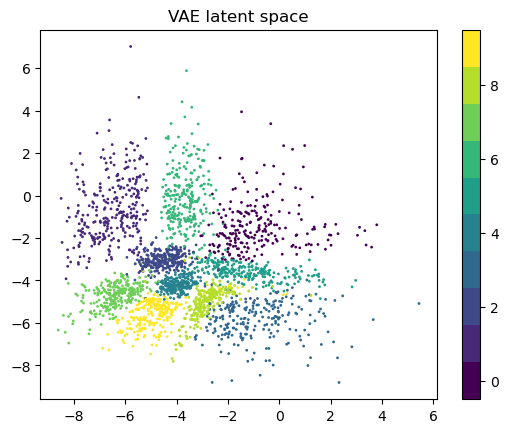

In [48]:
import matplotlib.pyplot as plt
import numpy as np

Data = []
Labels = []
for _ in range(20):
    data, labels = next(iter(train_loader))
    z, _, _ = encoder(data)
    Data.append(z.detach().numpy())
    Labels.append(labels.detach().numpy())

Data = np.concatenate(Data, axis=0)
Labels = np.concatenate(Labels, axis=0)

cmap = plt.get_cmap('viridis', 10)
sc = plt.scatter(Data[:, 0], Data[:, 1], c=Labels, 
            cmap=cmap, 
            vmin=-0.5, vmax=9.5, 
            marker='o', s=1)
plt.colorbar(sc)
plt.title('VAE latent space')
plt.show()

Now we can define the objective function and surrogate model

In [186]:
import os
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms import Standardize, Normalize
from scipy.stats import multivariate_normal

d = latent_dim
dtype = torch.float32
SMOKE_TEST = os.environ.get("SMOKE_TEST", False)
bounds = torch.tensor([[-8.0] * d, [8.0] * d], device=device, dtype=dtype)

def nll(t, target):
    '''
    Bayesian optimization objective.
    '''
    # Decode latent vector into image
    mvn = multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]])
    # Predict probabilities with separate classifier
    c_probs = nn.functional.softmax(classifier(t),dim=-1)
    c_probs = c_probs.detach().numpy()
    nll_prior = 0 #mvn.logpdf(t).reshape(-1, 1)
    nll_pred = -np.log(c_probs[:,target] + 1e-8).reshape(-1, 1)
    
    return torch.tensor(nll_prior + nll_pred)

def optimizer_for(target):
    
    def nll_target(t):
        return nll(t, target)
    return nll_target

def gen_initial_data(score_image,n=5):
    # generate training data
    train_x = unnormalize(
        torch.rand(n, d, device=device, dtype=dtype), 
        bounds=bounds
    )
    train_obj = score_image(train_x)
    best_observed_value = train_obj.max().item()
    return train_x, train_obj, best_observed_value


def get_fitted_model(train_x, train_obj, state_dict=None):
    # initialize and fit model
    model = SingleTaskGP(
        train_X=normalize(train_x, bounds), 
        train_Y=train_obj,
        outcome_transform=Standardize(m=1)
    )
    if state_dict is not None:
        model.load_state_dict(state_dict)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    fit_gpytorch_mll(mll)
    return model

In [187]:
from botorch.optim import optimize_acqf


BATCH_SIZE = 3 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 256 if not SMOKE_TEST else 4


def optimize_acqf_and_get_observation(acq_func,score_image):
    """Optimizes the acquisition function, and returns a
    new candidate and a noisy observation"""

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.stack(
            [
                torch.zeros(d, dtype=dtype, device=device),
                torch.ones(d, dtype=dtype, device=device),
            ]
        ),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )

    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=bounds)
    new_obj = score_image(new_x)
    return new_x, new_obj

In [210]:
target = 6
score_image = optimizer_for(target)

In [211]:
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

seed = 1
torch.manual_seed(seed)

N_BATCH = 50
best_observed = []

# call helper function to initialize model
train_x, train_obj, best_value = gen_initial_data(score_image,n=5)
best_observed.append(best_value)

In [212]:
import warnings

warnings.filterwarnings("ignore")


print(f"\nRunning BO ", end="")

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(N_BATCH):

    # fit the model
    model = get_fitted_model(
        train_x=train_x,
        train_obj=train_obj.type(torch.float32),
        state_dict=state_dict,
    )

    # define the qNEI acquisition function
    qEI = qExpectedImprovement(
        model=model, best_f=train_obj.max()
    )

    # optimize and get new observation
    new_x, new_obj = optimize_acqf_and_get_observation(qEI,score_image)

    # update training points
    train_x = torch.cat((train_x, new_x))
    train_obj = torch.cat((train_obj, new_obj))

    # update progress
    best_value = train_obj.max().item()
    best_observed.append(best_value)

    state_dict = model.state_dict()

    print(".", end="")


Running BO ..................................................

Let's see the best samples from the latent space found by the BO algorithm after passed through the decoder.

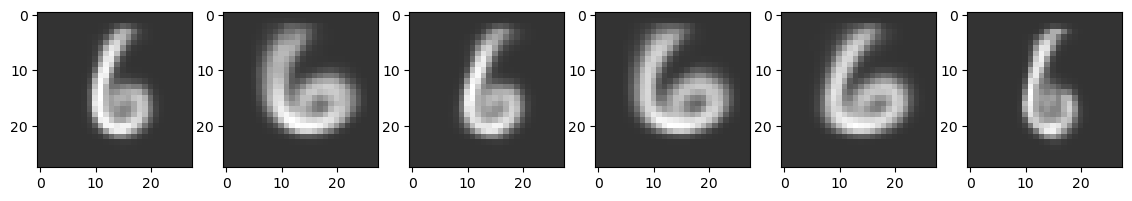

In [213]:
ind = np.argsort(train_obj.squeeze().detach().numpy())
fig, ax = plt.subplots(1, 6, figsize=(14, 14))
for i, ax in enumerate(ax.flat):
    img = decoder(train_x[ind[i]].view(1, -1)).squeeze().detach().numpy()
    ax.imshow(img, alpha=0.8, cmap="gray")